# Project 2: Continous control

---

In this notebook, we start and interact with the environment to train agents or watch them control a multi-joint robotic arm.

### 1. Necessary imports and defining the constants

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [5]:
from collections import deque
import pickle

import numpy as np
import pandas as pd
import torch
from unityagents import UnityEnvironment
from tqdm import tqdm
import matplotlib.pyplot as plt

from ddpg_agent_orig import Agent
import Config

%matplotlib inline 

# Initialize the config in which all hyperparams are stored
config = Config.config()

Next, we will define all the constants relevant to this notebook. This is the only cell you need to modify. The rest of the notebook should run without any modifications.
Change the `env_file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [8]:
env_file_name = 'Reacher_Windows_x86_64_twenty/Reacher.exe' # Path to the Unity environment.
per = True                                                  # Priotirized experience replay buffer
n_episodes = 400                                            # Number of episodes to train on
n_episodes_to_watch = 1                                     # Numbers of episodes to watch the trained agent

### 2. Setting up the environment

In this step we start the environment, save the `brain_name`, which we need to interact with the environment and save the size of the state- and action-space.

In [4]:
env = UnityEnvironment(file_name=env_file_name)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size

# dimension of the state-space 
num_agents = env_info.vector_observations.shape[0]
state_size = env_info.vector_observations.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Train an agent

In the next code cells we define a training-method and anfter that initialize and train agents. The trained model-parameters will be saved every 250 episodes in `checkpoint_{model_suff}.pth`. It loops through all specified agent-parameters. If `per==True` it will prepopulate the memory with experiences from random actions before training.

Training will be done on the gpu if one is available.

If you just want to analyse already trained agent, you can skip this section.

In [ ]:
def prepop_memory(agent, env, action_size):
    """ Prepoulates the memory with experiences 
    from random actions if training with prioritized experience replay.
    
    Params
    ======
        agent (Agent): instance of class Agent which memory should be filled.
        env (reacher environment): environment to interact with.
    """
    
    
    print("Prepopulating Memory...")
    pretrain_length = agent.memory.tree.capacity 
    
    actions = 2*np.random.rand(pretrain_length//agent.num_agents, agent.num_agents, action_size) - 1
    
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations

    for i in tqdm(range(actions.shape[0])):
               
        # Random action
        action = actions[i]
        
        # Take the action
        env_info = env.step(action)[brain_name] 

        # Get next_state, reward and done
        next_state = env_info.vector_observations   # get the next state
        reward = env_info.rewards                   # get the reward
        done = env_info.local_done                  # see if episode has finished

        # Store the experiences in the memory
        # Save experience of each agent in replay memory
        for i in range(agent.num_agents):
            agent.memory.add(state[i,:], action[i,:], reward[i], next_state[i,:], done[i])

        #agent.memory.add(state, action, reward, next_state, done)
               
        # Reset env if done
        if done:
            env_info = env.reset(train_mode=True)[brain_name] # reset the environment
            state = env_info.vector_observations
        else:
            state = next_state
    pickle.dump(agent.memory,open('agent_memory_per_init.pkl','wb'))
    return agent

def train_agent(n_episodes=2000, model_suff=""):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        model_suff (str): string wich will be appended to the saved model-parameters
    """
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations
        score = np.zeros(agent.num_agents)

        # Decay the action-noise and reset randomer
        agent.decay_epsilon()
        agent.reset()

        while True:
            
            action = agent.act(state)
            env_info = env.step(action)[brain_name]         # send the action to the environment
            next_state = env_info.vector_observations       # get the next state
            reward = env_info.rewards                       # get the reward
            done = env_info.local_done                      # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += np.array(reward)
           
            if np.any(done): 
                break 

        scores_window.append(np.mean(score))       # save most recent score
        scores.append(np.mean(score))              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}\tLast Score: {:.2f}'.format(i_episode, np.mean(scores_window), scores[-1]), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.critic.state_dict(), f"checkpoint_critic_episode_{model_suff}.pth")
            torch.save(agent.actor.state_dict(), f"checkpoint_actor_episode_{model_suff}.pth")
            pickle.dump(scores, open(f"Scores_interrim_{model_suff}.pkl", 'wb'))
        if (np.array(scores_window)>=30).all() or (i_episode>=n_episodes+1):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.critic.state_dict(), f"checkpoint_critic_episode_final_{model_suff}.pth")
            torch.save(agent.actor.state_dict(), f"checkpoint_actor_episode_final_{model_suff}.pth")
            pickle.dump(scores, open(f"Scores_final_{model_suff}.pkl", 'wb'))
            break
    return scores

In [ ]:
# Create the Agent and let it train
agent = Agent(config=config, 
                state_size=state_size, 
                action_size=action_size, 
                num_agents=num_agents, 
                seed=0, per=per)
if per: agent = prepop_memory(agent, env)

# Train the agent and save the scores for later analysis
scores = train_agent(n_episodes=n_episodes, model_suff=suff)

Agent woper is now training...
Prepopulating the Memory...

 11%|███▊                              | 11185/100000 [00:34<04:38, 318.52it/s]

### 4. Whatch trained agents
Next we can watch a trained agent control 20 robotic arms for `n_episodes_to_watch` episodes. Therefore we load the model-parameters, reset the environment and loop through the specified number of episodes only using the calculated actions without any random noise. 

In [12]:
agent = Agent(config=config, 
                state_size=state_size, 
                action_size=action_size, 
                num_agents=num_agents, 
                seed=0, per=per)
agent.actor.load_state_dict(torch.load("checkpoint_actor_episode_wper.pth", map_location=agent.config.device))
agent.critic.load_state_dict(torch.load("checkpoint_critic_episode_wper.pth", map_location=agent.config.device))
agent.is_training = False

scores = []                            # list containing scores from each episode
for i_episode in range(1, n_episodes_to_watch+1):    # Loop through five episodes
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations
    score = np.zeros(num_agents)
    while True:
        action = agent.act(state)
        
        env_info = env.step(action)[brain_name]        # send the action to the environment
        state = env_info.vector_observations             # get the next state
        reward = env_info.rewards                        # get the reward
        done = env_info.local_done                       # see if episode has finished

        score += reward                                     # update the score

        if np.any(done):
            break 
    scores.append(np.mean(score))              # save most recent score
print(f"Avg. score: {np.mean(scores):.3}")

Avg. score: 29.5


### 5. Plot the learning-curve
In the last section we want to take a look at the learning curve. For orientation the goal-score (30) is also plottet.

Text(0,0.5,'Score')

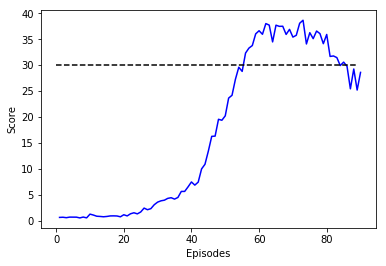

In [19]:
training_scores = pickle.load(open("Scores_interrim_wper.pkl", 'rb'))
plt.plot(range(1,len(training_scores)+1), training_scores, 'b')
plt.plot(np.ones(len(training_scores))*30, 'k--')
plt.xlabel('Episodes')
plt.ylabel('Score')

### 6. Close the environment

In [12]:
env.close()